# Data import and Set-up

First, we will import our libraries.

In [3]:
import re
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
#import xgboost as xgb

from collections import Counter
import sklearn

# Scikit-learn libraries for model building
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA

# Scikit-learn libraries for evaluation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import log_loss
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import *

# Imbalanced learn libraries to handle unbalanced data
#from imblearn.over_sampling import *
#from imblearn.under_sampling import *

# Ignoring all warnings throughout the notebook
import warnings
warnings.filterwarnings('ignore')

sklearn.__version__

'0.23.2'

Now, we will fetch the latest dataset available in Austin Texas Dataset, and we will adapt the format of the dataset, to fit with future work.

In [4]:
import requests
import os.path

if os.path.isfile('./data/train.csv') and os.path.isfile('./data/test.csv'):
    print ("Datasets already fetched, delete them if you want the latest datasets!")
else:
    print ("Downloading and preparing datasets...")

    outcomes_endpoint = 'https://data.austintexas.gov/resource/9t4d-g238.json'

    params = {'$limit': 10000000} # If not specified it only returns 1000 records
    request = requests.get(outcomes_endpoint, params)
    out_df = pd.DataFrame(request.json())

    # Drop two unnecessary columns. 
    out_df.drop(['monthyear', 'date_of_birth'], axis=1, inplace=True)

    # Re-order Columns
    out_df = out_df[['animal_id','name','datetime','outcome_type','outcome_subtype', 
                     'animal_type', 'sex_upon_outcome', 'age_upon_outcome', 'breed', 'color']]

    # Re-name Columns
    out_df.columns = ['AnimalID','Name','DateTime','OutcomeType','OutcomeSubtype', 'AnimalType', 
                      'SexuponOutcome', 'AgeuponOutcome', 'Breed', 'Color']
    
    # Clean unnecessary rows, we will focus on the 4 main outcomes.
    out_df = out_df.drop(out_df[out_df['OutcomeType'] == 'Rto-Adopt'].index)
    out_df = out_df.drop(out_df[out_df['OutcomeType'] == 'Disposal'].index)
    out_df = out_df.drop(out_df[out_df['OutcomeType'] == 'Missing'].index)
    out_df = out_df.drop(out_df[out_df['OutcomeType'] == 'Relocate'].index)
    
    # Clean Bird/Livestock rows, there is no enough data.
    out_df = out_df.drop(out_df[out_df['AnimalType'] == 'Bird'].index)
    out_df = out_df.drop(out_df[out_df['AnimalType'] == 'Livestock'].index)
    
    # Split dataset
    #train_df, test_df = train_test_split(out_df, test_size=0.2, shuffle=True)

    # Drop columns in test_df
    #test_df.drop(['OutcomeType', 'OutcomeSubtype'], axis=1, inplace=True)

    # Re-name Columns in test_df
    #test_df.columns = ['ID','Name','DateTime', 'AnimalType', 
    #                 'SexuponOutcome', 'AgeuponOutcome', 'Breed', 'Color']
    # Reset the IDs in test_df
    #out_df['ID'] = np.arange(len(test_df.index))

    # Save both dataframes
    if not os.path.exists('./data'):
        os.makedirs('./data')
        
    out_df.to_csv('./data/out_df.csv', index=False)
    #test_df.to_csv('./data/test.csv', index=False)
    
    print("Done.")

Done.


Next, we load our data, which had already been separated into training and test data.

In [5]:
# Training and test dataframes, and its structure.
out_df = pd.read_csv('./data/out_df.csv')
#test_df = pd.read_csv('./data/test.csv')

# Exporatory Data Analysis (EDA)
First, we look if we have outliers of missing data for each feature.

In [6]:
# Describe the dataset.
out_df.describe()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
count,121732,83882,121732,121722,56459,121732,121730,121725,121732,121732
unique,108962,19520,100617,5,22,3,5,50,2528,577
top,A721033,Max,2016-04-18T00:00:00.000,Adoption,Partner,Dog,Neutered Male,1 year,Domestic Shorthair Mix,Black/White
freq,31,547,39,54677,30456,69358,43051,21271,31162,12843


In [7]:
# Show percent of total data in the training dataframe

In [8]:
out_df_counts = pd.DataFrame({'Column Count' : out_df.count(),
   ....:                      '% Percent of Total Data' : out_df.count().div(max(out_df.count())) * 100})

out_df_counts.round(1)

,Column Count,% Percent of Total Data
AnimalID,121732,100.0
Name,83882,68.9
DateTime,121732,100.0
OutcomeType,121722,100.0
OutcomeSubtype,56459,46.4
AnimalType,121732,100.0
SexuponOutcome,121730,100.0
AgeuponOutcome,121725,100.0
Breed,121732,100.0
Color,121732,100.0


Our initial look at the data reveals 97,216 rows. `Name` is not included for 30,503 cases, but is included for 68.6% of the data. A large quantity of `OutcomeSubtype` data is missing, which we worked to quantify below. Aside from these two columns, we had at least 99.9% of the data in every other column.

We are choosing not to use the `Name` variable, as we have blanks for 31.4% of the data, and animals have high variety of names, so the variable had few commonalities among animals. We feel that this level of sparsity within `Name` will not help us to predict the animals outcomes. This makes logical sense as well, as `Name` seems unlikely to be the deciding factor in whether an animal is adopted.

# Class Variable Review

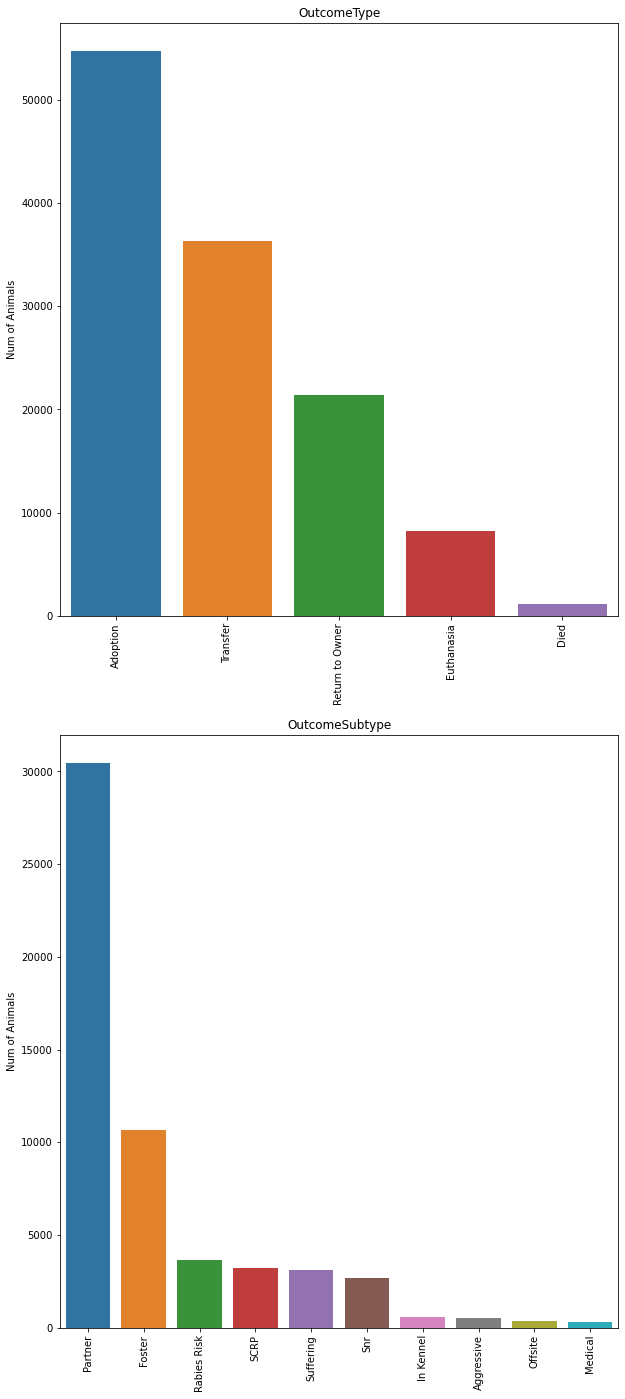

In [9]:
# Obtain headers.
headers = out_df.dtypes.index

# Categorical headers of classes.
cat_headers = ['OutcomeType', 'OutcomeSubtype']

# Plot paretos of top 10 values in each column.
fig, ax = plt.subplots(len(cat_headers[0:]), 1, figsize=(10, len(cat_headers)*12))
for i, column in enumerate(cat_headers[0:]):
    to_plot=out_df[column].value_counts().head(10)
    plot=sns.barplot(x=to_plot.index, y=to_plot, ax=ax[i])
    plot.set_xticklabels(to_plot.index, rotation=90)
    plot.set_title(column)
    plot.set_ylabel("Num of Animals")
fig.show()

Overall, we see a large imbalance between the outcome classes, which we will discuss further below in our modeling section. The outomes lean heavily toward Adoption, Transfer, and Return to Owner. There is a smaller portion of Euthanasia outcomes, and a very small number of Died outomes.

While the `Outcome Subtype` variable is also missing for many animals, we do not predict based on this variable.

In [10]:
out_df_sub = out_df[out_df['OutcomeSubtype'].isnull()]
out_df_sub.head()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
7,A806716,Sharkie,2021-01-14T17:39:00.000,Return to Owner,NaN,Dog,Neutered Male,4 years,Miniature Poodle/Maltese,Tan/White
8,A816200,Paloma,2021-01-14T17:39:00.000,Return to Owner,NaN,Dog,Spayed Female,2 years,Maltese,White/Brown
9,A806718,Canelo,2021-01-14T17:31:00.000,Return to Owner,NaN,Dog,Neutered Male,1 year,Miniature Poodle/Maltese,Tan/White
10,A827992,Luna,2021-01-14T17:28:00.000,Adoption,NaN,Dog,Spayed Female,2 months,Catahoula Mix,White/Tan
11,A828082,*Falcor,2021-01-14T16:36:00.000,Adoption,NaN,Dog,Neutered Male,2 years,Anatol Shepherd Mix,Tan


From the data in the table above, we surmise that it is possible the majority of the subtype null data is from the `Return to Owner` or `Adoption` outcome type data. We will examine this further below.

In [11]:
out_df_sub_2 = out_df_sub['OutcomeType'].value_counts().reset_index(name='Count of Null')
out_df_sub_2.rename(index=str, columns={"index": "Outcome Types"})

,Outcome Types,Count of Null
0,Adoption,43632
1,Return to Owner,21308
2,Euthanasia,219
3,Died,104


34,777 of the Adoption outcome entries have the outcome subtype as `null`. As we already have outcome subtypes for barn, foster, and offsite within adoption, we feel confident in assuming that these missing subtypes are simply the animals that were adopted. We will assume this is true and fill these null values with `adopted`.

As the return-to-owner outcome type also has no subtype, we will make the outcome subtype `return to owner`. It seems that, within the dataset, when the outcome subtype would have been redundant with the outcome type, the outcome subtype was not always listed. Logically, once an animal is adopted or returned to their owner, a shelter feels it does not need further classification or follow up on specific outcomes.

For the remaining 23 null outcome subtypes, we will label their subtype as `other`.

In [13]:
def subtype(x):
    if x['OutcomeType'] == 'Adoption' and pd.isnull(x['OutcomeSubtype']) : return 'Adopted'
    elif x['OutcomeType'] == 'Return_to_owner' and pd.isnull(x['OutcomeSubtype']): return 'Return to Owner'
    elif pd.isnull(x['OutcomeSubtype']) : return 'Other'
    else: return x['OutcomeSubtype']

out_df['OutcomeSubtype'] = out_df.apply(subtype, axis=1)

In [14]:
out_df.groupby(['OutcomeType', 'OutcomeSubtype']).size().reset_index(name='Count')

,OutcomeType,OutcomeSubtype,Count
0,Adoption,Adopted,43632
1,Adoption,Barn,3
2,Adoption,Foster,10661
3,Adoption,Offsite,381
4,Died,At Vet,88
5,Died,Enroute,82
6,Died,In Foster,270
7,Died,In Kennel,569
8,Died,In Surgery,22
9,Died,Other,104


# Feature Review
Following the class review, we will now review the specific features themselves. We begin by performing a graphic review of the distribution of values among features in the training set. 

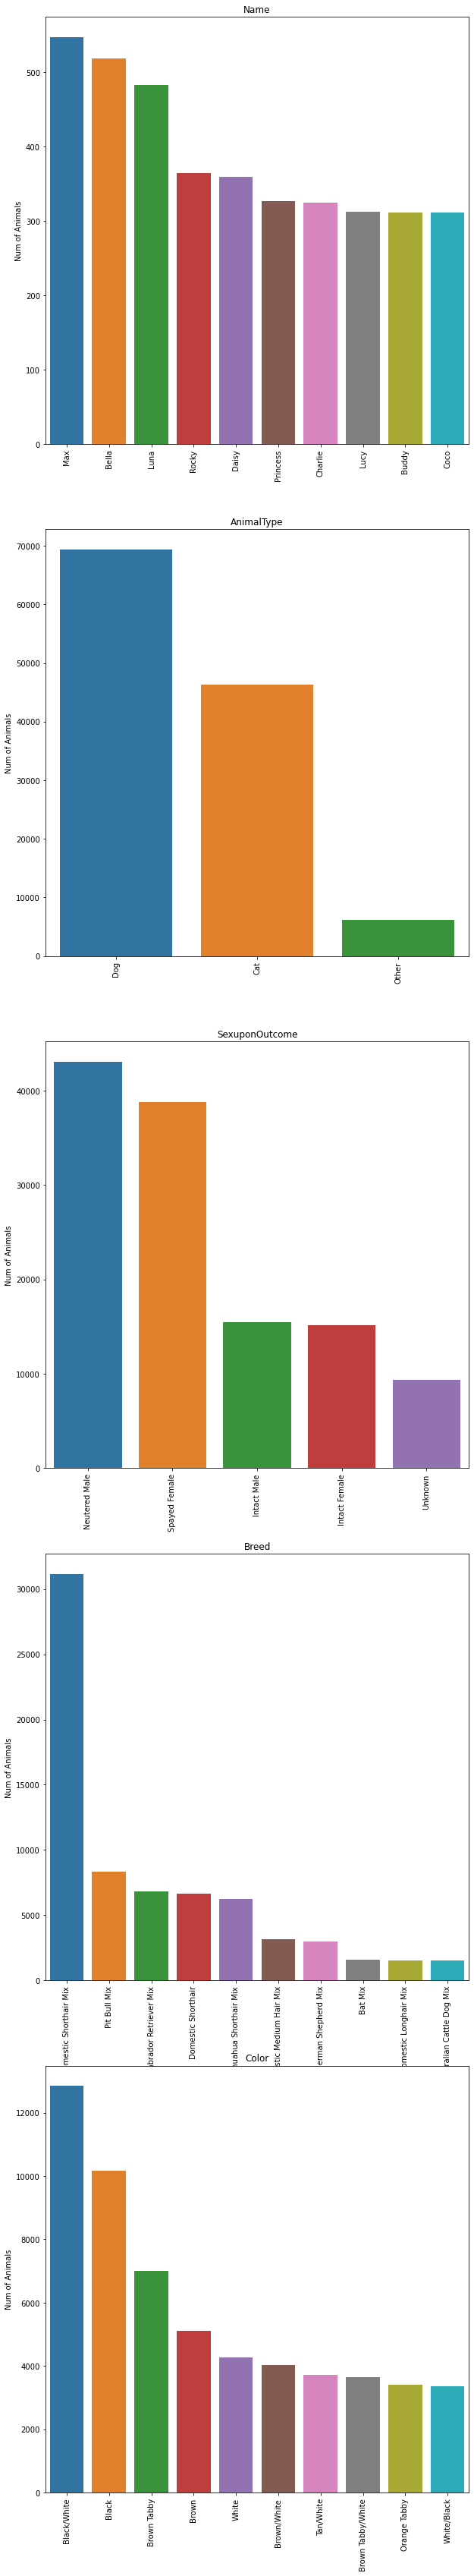

In [15]:
# Obtain headers.
headers = out_df.dtypes.index

# Not all of these are categorical variables.  
# We need categorical headers and continuous headers, with two different types of plots.

# Categorical headers of features.
cat_headers = ['Name', 'AnimalType', 'SexuponOutcome', 'Breed', 'Color']

# Plot paretos of top 10 values in each column.
fig, ax = plt.subplots(len(cat_headers[0:]), 1, figsize=(10, len(cat_headers)*12))
for i, column in enumerate(cat_headers[0:]):
    to_plot=out_df[column].value_counts().head(10)
    plot=sns.barplot(x=to_plot.index, y=to_plot, ax=ax[i])
    plot.set_xticklabels(to_plot.index, rotation=90)
    plot.set_title(column)
    plot.set_ylabel("Num of Animals")
fig.show()

A breakdown of `Animal Type` shows that there are mainly dogs and cats in the dataset, with dogs accounting for about 60% of cases. The is a quite big portion of Other animals, and a very little quantity of Bird and Livestock types.

`Sex Upon Outcome` shows us whether the animal is male or female and whether they were spayed or neutered (fixed) prior to the outcome. There is a roughly even split between male and female animals, an overwhelming majority of which were spayed or neutered upon outcome. There are also a small, but notable, quantity of unknowns. We will look further below at this variable's interaction with animal outcomes.

The `Breed` feature is dominated by domestic shorthair cats, which is a catch-all breed label and by far the most common type of cat. There are nearly 25,000 of these. No other breed exceeds 7,000. The most common dog breed is Pitbull Mix.

The most common `Color` is Black/White, followed closely by Black. Taken together as predominantly black, these two colors would substantially outweigh any others. Brown Tabby and Brown Tabby/White are the next most common colors, which is interesting, as these are colors that are only attributable to cats. Black/White and Black could be either dogs or cats. The other top colors are evenly distributed.

In [16]:
out_df_sex_dropna = out_df.dropna(subset=['SexuponOutcome'])
out_df_sex_outcome = out_df_sex_dropna.groupby(['OutcomeType', 'SexuponOutcome']).agg({'AnimalType':'size'}).rename(columns={'AnimalType':'# of Animals'}).reset_index()
out_df_sex_outcome

,OutcomeType,SexuponOutcome,# of Animals
0,Adoption,Intact Female,1162
1,Adoption,Intact Male,960
2,Adoption,Neutered Male,26556
3,Adoption,Spayed Female,25932
4,Adoption,Unknown,67
5,Died,Intact Female,291
6,Died,Intact Male,350
7,Died,Neutered Male,92
8,Died,Spayed Female,82
9,Died,Unknown,320


Examining the distribution of sexes per outcome illuminates the story better than the earlier graphic representation. More than 40,000 of the adopted animals were spayed or neutered upon adoption. Only 1802 were not. Of the animals that were returned to owners, a large majority had also been spayed or neutered. Among the other category, spayed/neutered/male/female were all evenly distributed. Most of the unknowns are seen in the transfer outcome. We will look to binarize gender and whether an animal was fixed for our analysis below.

Next, we look into the Age Upon Outcome feature variable. We believed that it is important to make the ages variable continuous, as opposed to categorical, as the relationship of age is continuous in nature. The most logical unit to standardize ages is weeks. Most of the ages are given in weeks, months, or years, all of which easily transform to weeks. Several ages are given in days, but all are 6 days or fewer. We will standardize these as zero weeks so that they are on the same scale as the rest of the data.

In [17]:
# Map all AgeuponOutcome values to numbers. Mapped to weeks and rounded to the nearest week.
out_df['AgeuponOutcome'] = out_df['AgeuponOutcome'].map({'1 week': 1, '1 weeks': 1, '2 weeks': 2, '3 weeks': 3,
                                                             '4 weeks': 4, '5 weeks': 5, '1 month': 4, '2 months': 9,
                                                             '3 months': 13, '4 months': 17, '5 months': 21, 
                                                             '6 months': 26, '7 months': 30, '8 months': 34, 
                                                             '9 months': 38, '10 months': 43, '11 months': 47, 
                                                             '1 year': 52, '2 years': 204, '3 years': 156,
                                                             '4 years': 208, '5 years': 260, '6 years': 312, 
                                                             '7 years': 364, '8 years': 416, '9 years': 468, 
                                                             '10 years': 520, '11 years': 572, '12 years': 624, 
                                                             '13 years': 676, '14 years': 728, '15 years': 780, 
                                                             '16 years': 832, '17 years': 884, '18 years': 936, 
                                                             '20 years': 1040, '0 years': 26, '1 day': 0, '2 days': 0,
                                                             '3 days': 0, '4 days': 0, '5 days': 0, '6 days': 0})

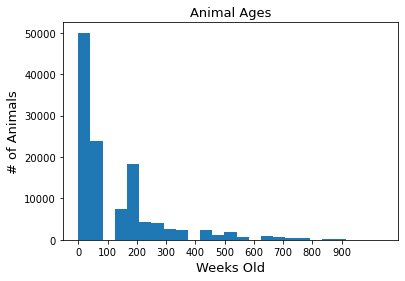

In [18]:
out_df_age_dropna = out_df.dropna(subset=['AgeuponOutcome'])

plt.hist(out_df_age_dropna['AgeuponOutcome'], bins = 25) 

plt.title("Animal Ages")
plt.xlabel("Weeks Old")
plt.ylabel("# of Animals")
plt.xticks(np.arange(0, 1000, step=100))

# Font size transformations.
ax = plt.gca()
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label]):
    item.set_fontsize(13)

plt.grid(False)

A substantial portion of the animals in the dataset reached their outcomes at under one year of age (52 weeks). We see sizable numbers of outcomes up to the four-year mark (208 weeks). After four years of age, outcomes drop precipitously.

In [19]:
out_df_age_dropna_2 = out_df_age_dropna[(out_df_age_dropna.AgeuponOutcome <= 104)]
out_df_age_dropna_3 = out_df_age_dropna[(out_df_age_dropna.AgeuponOutcome <= 156)]
print("Examining the ages of younger animals further, ", round((out_df_age_dropna_2.shape[0] / 
                                                                out_df_age_dropna.shape[0])*100,2), 
      "% of animals are under the age of two years old and ", round((out_df_age_dropna_3.shape[0] / 
                                                                     out_df_age_dropna.shape[0])*100,2),
     "% are under the age of three years old.", sep="")

Examining the ages of younger animals further, 60.7% of animals are under the age of two years old and 66.79% are under the age of three years old.


In [20]:
out_df_age_outcome = out_df_age_dropna.groupby('OutcomeType').agg({'AnimalType':'size', 
                                                                       'AgeuponOutcome':'mean'}).rename(columns={'AnimalType':'# of Animals',
                                                                                                                 'AgeuponOutcome':'Avg. Age Upon Outcome (in Wk)'}).reset_index()
print("Avg. Age of Animals Upon Outcome:", (round(out_df_age_dropna.AgeuponOutcome.mean())), "weeks")

out_df_age_outcome.round(1)

Avg. Age of Animals Upon Outcome: 124 weeks


,OutcomeType,# of Animals,Avg. Age Upon Outcome (in Wk)
0,Adoption,54676,99.1
1,Died,1135,87.2
2,Euthanasia,8200,150.1
3,Return to Owner,21333,224.2
4,Transfer,36331,97.4


From the information above, we can see that a more likely outcome for younger animals is to be `Transfer` or `Adoption`, while older animals are more likely to be `returned to their owner` or `euthanized`. While the `Died` outcome has the lowest average age upon outcome, only 0.7% of animals fall into this category. Therefore, we can assume that many of these animals were unhealthy upon birth and died young.

The age variable is explicitly defined as the age upon outcome; we do not know the ages of animals when they entered shelters. We also do not know how long animals were at the shelter prior to their outcome, and we have no insights into animals still in shelters.

Next, we will look at the `DateTime` column to understand a little more about trends over time in the dataset. We will assume that the `DateTime` column references when the outcome of each animal was determined. We will evaluate this information over time by week to group the data.

In [21]:
out_df.head(5)

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,A828315,NaN,2021-01-15T13:07:00.000,Transfer,Partner,Dog,Intact Female,NaN,Chihuahua Shorthair,White/Tan
1,A813546,Milo,2021-01-15T13:07:00.000,Transfer,Partner,Dog,NaN,NaN,Chihuahua Shorthair Mix,White/Tan
2,A828229,NaN,2021-01-15T12:15:00.000,Transfer,Partner,Dog,Spayed Female,43.0,Chihuahua Shorthair,Brown/White
3,A828228,NaN,2021-01-15T12:15:00.000,Transfer,Partner,Dog,Neutered Male,26.0,Border Terrier,Brown/Tan
4,A828241,NaN,2021-01-15T12:15:00.000,Transfer,Partner,Dog,Intact Male,43.0,Pomeranian Mix,Tan/Black


In [22]:
# Convert our DateTime column to the proper format and then group by week.
out_df['DateTime'] = pd.to_datetime(out_df['DateTime']) - pd.to_timedelta(7, unit='d')
out_df_time = out_df.groupby([pd.Grouper(key='DateTime', freq='W-SUN')]).size().reset_index().sort_values('DateTime')
out_df_time.columns = ['DateTime', 'All']

# Filter for the specific outcome types so that we can later look at the differences by outcome type.
headers = ['Adoption', 'Transfer', 'Return to Owner', 'Euthanasia', 'Died']
for Outcome in headers:
    out_df_outcome = out_df[out_df.OutcomeType == Outcome].groupby([pd.Grouper(key='DateTime', freq='W-SUN')]).size().reset_index().sort_values('DateTime')
    out_df_time = pd.merge(out_df_time, out_df_outcome, on='DateTime', how='outer')

# Rename the columns to represent each outcome header.
out_df_time.columns = ['DateTime', 'All', 'Adoption', 'Transfer', 'Return to Owner', 'Euthanasia', 'Died']

out_df_time

,DateTime,All,Adoption,Transfer,Return to Owner,Euthanasia,Died
0,2013-09-29,306,116,101,57,28,4.0
1,2013-10-06,420,185,139,52,42,2.0
2,2013-10-13,388,130,162,58,36,2.0
3,2013-10-20,332,116,119,53,38,6.0
4,2013-10-27,336,157,91,46,41,1.0
...,...,...,...,...,...,...,...
376,2020-12-13,220,142,43,28,5,2.0
377,2020-12-20,120,82,21,14,3,0.0
378,2020-12-27,147,82,38,19,8,0.0
379,2021-01-03,139,76,32,19,7,1.0


No handles with labels found to put in legend.


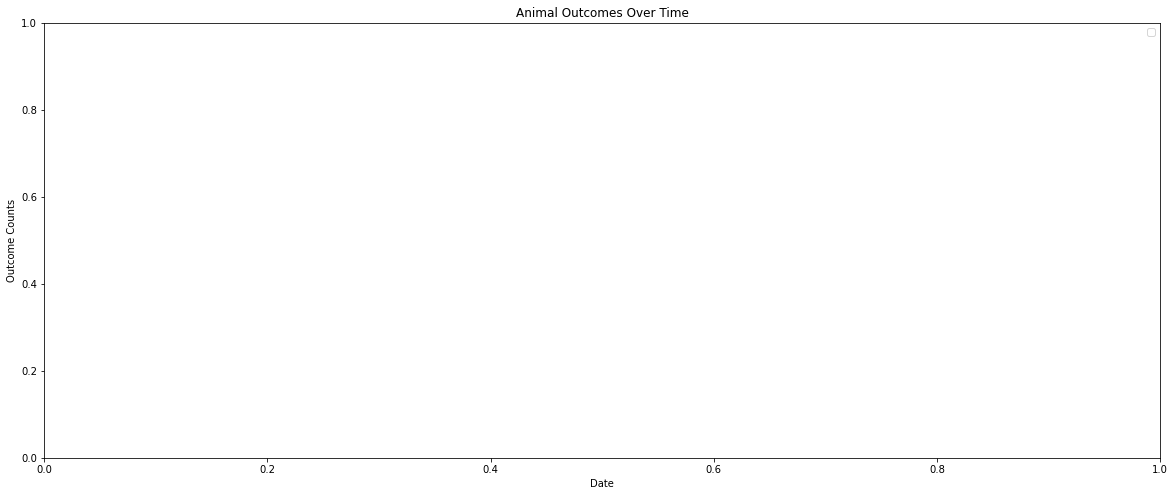

In [23]:
fig, ax = plt.subplots(figsize=(20, 8))
# ax = out_df_time.iloc[1:1, 1:1].plot(ax = ax, x=out_df_time['DateTime'], sort_columns=True, linewidth=3.0)

plt.xlabel('Date')
plt.ylabel('Outcome Counts')
plt.title('Animal Outcomes Over Time')
ax.legend()
plt.show()

From the `DateTime` analysis, we are able to evaluate animal outcomes from Sep 2013 through Dec 2020. We see that most animals are adopted in the summertime, around July and August. Adoption outcomes spike a bit during this time period as well; however, all other outcomes are evenly distributed throughout the time period of analysis.

# Feature Manipulation and Binarization

## Combining Features

Before binarizing features, we thought doing some simple feature selection could be a good first start. As the breed type has over 2,300 variations and color has over 500 variations, we will see if combining any like features could make sense.

In [24]:
# Evaluate the Breed feature set for combination.
out_df_breed_list = out_df['Breed'].tolist()
out_df_breed_dict = {i:out_df_breed_list.count(i) for i in set(out_df_breed_list)}

print("Number of unique breeds within the dataset:", out_df['Breed'].describe()[1])

# Analyze the different combinations of breeds.
for k in sorted(out_df_breed_dict): 
    print(k,": ",out_df_breed_dict[k], sep="", end=", ")

Number of unique breeds within the dataset: 2528


Abyssinian: 8, Abyssinian Mix: 9, Affenpinscher: 1, Affenpinscher Mix: 8, Afghan Hound Mix: 1, Afghan Hound/German Shepherd: 1, Afghan Hound/Labrador Retriever: 1, Airedale Terrier: 2, Airedale Terrier Mix: 28, Airedale Terrier/Irish Terrier: 1, Airedale Terrier/Labrador Retriever: 2, Airedale Terrier/Miniature Schnauzer: 1, Airedale Terrier/Otterhound: 2, Airedale Terrier/Standard Poodle: 1, Akbash Mix: 6, Akita: 16, Akita Mix: 52, Akita/Australian Cattle Dog: 6, Akita/Belgian Malinois: 2, Akita/Border Collie: 3, Akita/Chow Chow: 1, Akita/German Shepherd: 6, Akita/Great Pyrenees: 1, Akita/Labrador Retriever: 3, Akita/Mastiff: 1, Akita/Pit Bull: 2, Akita/Siberian Husky: 4, Alaskan Husky: 63, Alaskan Husky Mix: 124, Alaskan Husky/Australian Shepherd: 3, Alaskan Husky/Border Collie: 3, Alaskan Husky/Catahoula: 2, Alaskan Husky/Chow Chow: 1, Alaskan Husky/German Shepherd: 30, Alaskan Husky/Labrador Retriever: 8, Alaskan Husky/Miniature Pinscher: 1, Alaskan Klee Kai: 1, Alaskan Malamute: 1

, German Shepherd Mix: 2974, German Shepherd/Airedale Terrier: 2, German Shepherd/Akita: 4, German Shepherd/Alaskan Husky: 34, German Shepherd/Alaskan Malamute: 6, German Shepherd/Anatol Shepherd: 10, German Shepherd/Australian Cattle Dog: 40, German Shepherd/Australian Kelpie: 15, German Shepherd/Australian Shepherd: 12, German Shepherd/Basenji: 1, German Shepherd/Basset Hound: 1, German Shepherd/Beagle: 3, German Shepherd/Belgian Malinois: 3, German Shepherd/Black Mouth Cur: 16, German Shepherd/Black/Tan Hound: 8, German Shepherd/Border Collie: 15, German Shepherd/Border Terrier: 1, German Shepherd/Boxer: 21, German Shepherd/Bull Terrier: 2, German Shepherd/Bull Terrier Miniature: 1, German Shepherd/Cardigan Welsh Corgi: 12, German Shepherd/Carolina Dog: 1, German Shepherd/Catahoula: 16, German Shepherd/Chihuahua Shorthair: 4, German Shepherd/Chinese Sharpei: 9, German Shepherd/Chow Chow: 30, German Shepherd/Collie Rough: 7, German Shepherd/Collie Smooth: 4, German Shepherd/Doberman 

Manchester Terrier: 5, Manchester Terrier Mix: 120, Manchester Terrier/Australian Kelpie: 2, Manchester Terrier/Basenji: 1, Manchester Terrier/Beagle: 6, Manchester Terrier/Chihuahua Longhair: 1, Manchester Terrier/Chihuahua Shorthair: 11, Manchester Terrier/Dachshund: 7, Manchester Terrier/Jack Russell Terrier: 3, Manchester Terrier/Labrador Retriever: 2, Manchester Terrier/Miniature Pinscher: 1, Manchester Terrier/Norfolk Terrier: 4, Manchester Terrier/Pembroke Welsh Corgi: 2, Manchester Terrier/Toy Fox Terrier: 1, Manx: 11, Manx Mix: 105, Manx/Domestic Longhair: 2, Manx/Domestic Medium Hair: 4, Manx/Domestic Shorthair: 4, Manx/Siamese: 1, Mastiff: 31, Mastiff Mix: 135, Mastiff/Akita: 1, Mastiff/American Pit Bull Terrier: 3, Mastiff/Anatol Shepherd: 1, Mastiff/Black Mouth Cur: 2, Mastiff/Bloodhound: 1, Mastiff/Boxer: 4, Mastiff/Cane Corso: 1, Mastiff/Chinese Sharpei: 7, Mastiff/Dutch Shepherd: 1, Mastiff/German Shepherd: 1, Mastiff/Great Dane: 2, Mastiff/Labrador Retriever: 5, Mastif

1, Siamese/Domestic Shorthair: 19, Siamese/Japanese Bobtail: 3, Siberian Husky: 419, Siberian Husky Mix: 687, Siberian Husky/Akita: 4, Siberian Husky/Alaskan Malamute: 4, Siberian Husky/American Pit Bull Terrier: 1, Siberian Husky/Anatol Shepherd: 3, Siberian Husky/Australian Cattle Dog: 18, Siberian Husky/Australian Shepherd: 1, Siberian Husky/Beagle: 1, Siberian Husky/Border Collie: 9, Siberian Husky/Cardigan Welsh Corgi: 1, Siberian Husky/Catahoula: 2, Siberian Husky/Chinese Sharpei: 2, Siberian Husky/French Bulldog: 1, Siberian Husky/German Shepherd: 57, Siberian Husky/Great Pyrenees: 1, Siberian Husky/Labrador Retriever: 29, Siberian Husky/Pit Bull: 10, Siberian Husky/Rottweiler: 1, Silky Terrier: 2, Silky Terrier Mix: 14, Silky Terrier/Maltese: 1, Silky Terrier/Yorkshire Terrier: 4, Silver Mix: 1, Skunk: 87, Skunk Mix: 97, Skye Terrier: 2, Skye Terrier Mix: 9, Skye Terrier/Miniature Poodle: 1, Smooth Fox Terrier: 10, Smooth Fox Terrier Mix: 49, Smooth Fox Terrier/Basenji: 1, Smoo

In [25]:
# Remove the secondary breed name.
def split_breed(x):
    if '/' in x['Breed'] : return x['Breed'].split('/', 1)[1]
    else : return x['Breed']
    
out_df['Breed'] = out_df.apply(split_breed, axis=1)

In [26]:
# Remove the word "mix" from the breed type.
out_df['Breed'] = out_df['Breed'].str.replace(' Mix', '')

In [27]:
print("We have taken the unique number of breeds from 1,380 to", 
      out_df['Breed'].describe()[1], "by removing the secondary breed type",
      "and the word \"mix\".")

We have taken the unique number of breeds from 1,380 to 325 by removing the secondary breed type and the word "mix".


In [28]:
# Evaluate the Color feature set for combination.
out_df_color_list = out_df['Color'].tolist()
out_df_color_dict = {i:out_df_color_list.count(i) for i in set(out_df_color_list)}

print("Number of unique colors within the dataset:", out_df['Color'].describe()[1])

# Analyzing the different combinations of colors.
for k in sorted(out_df_color_dict):
    print(k,": ",out_df_color_dict[k], sep="", end=", ")

Number of unique colors within the dataset: 577
Agouti: 20, Agouti/Brown Tabby: 1, Agouti/Cream: 1, Agouti/Gray: 1, Agouti/White: 2, Apricot: 77, Apricot/Brown: 3, Apricot/Tricolor: 2, Apricot/White: 12, Black: 10168, Black Brindle: 115, Black Brindle/Black: 10, Black Brindle/Blue: 1, Black Brindle/Blue Tick: 1, Black Brindle/Brown: 17, Black Brindle/Brown Brindle: 3, Black Brindle/Tan: 3, Black Brindle/White: 253, Black Smoke: 177, Black Smoke/Black: 1, Black Smoke/Black Tiger: 1, Black Smoke/Blue Tick: 1, Black Smoke/Brown: 2, Black Smoke/Brown Tabby: 1, Black Smoke/Chocolate: 1, Black Smoke/Gray: 1, Black Smoke/White: 50, Black Tabby: 234, Black Tabby/Black: 1, Black Tabby/Gray: 1, Black Tabby/Gray Tabby: 1, Black Tabby/Orange: 1, Black Tabby/White: 74, Black Tiger: 4, Black Tiger/White: 2, Black/Black: 160, Black/Black Brindle: 15, Black/Black Smoke: 6, Black/Black Tabby: 2, Black/Blue: 7, Black/Blue Merle: 20, Black/Blue Tick: 35, Black/Brown: 2590, Black/Brown Brindle: 150, Black

In [29]:
# Remove the secondary color name to focus on the principal color.
def split_color(x):
    if '/' in x['Color'] : return x['Color'].split('/', 1)[1]
    else : return x['Color']
    
out_df['Color'] = out_df.apply(split_color, axis=1)

In [30]:
print("We have taken the unique number of colors from 366 to", 
      out_df['Color'].describe()[1], "by focusing on the primary color",
      "\nand removing the secondary color.")

We have taken the unique number of colors from 366 to 59 by focusing on the primary color 
and removing the secondary color.


Moving forward, we are focusing on primary breed and color, working under the assumption that someone adopting an animal is likely to focus on the predominant feature in each of these categories. When a potential adopter sees border collie mix or border collie/labrador retriever, they are likely to process this as "border collie" first and foremost. Colors work the same way: the difference between calico vs. calico/white is negligible. 

The remaining colors could be reduced further, as they mix colors and coat types (blue vs. blue tabby), but we determined that these were unique enough to keep separate in a single field.

## Train Data Transformations and Binarization

In order to transform our dataset and make it ready for model evaluation, we are going to create dummy variables for all of our continuous variables and binarize all of our features. For our age variable, we are going to normalize all of the data, as the variable is continuous.

In [31]:
out_df_binarize = out_df.copy()
out_df_binarize.head(1)

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,A828315,NaN,2021-01-08 13:07:00,Transfer,Partner,Dog,Intact Female,NaN,Chihuahua Shorthair,Tan


In [32]:
# Split SexuponOutcome into dummy variables, so that both will only have two options.
out_df_binarize['State'], out_df_binarize['Gender'] = out_df_binarize['SexuponOutcome'].str.split(' ', 1).str

out_df_binarize['State'] = out_df_binarize['State'].map({'Neutered': 'Fixed', 
                                                             'Spayed': 'Fixed', 
                                                             'Intact': 'Intact'})
out_df_binarize.head(1)

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,State,Gender
0,A828315,NaN,2021-01-08 13:07:00,Transfer,Partner,Dog,Intact Female,NaN,Chihuahua Shorthair,Tan,Intact,Female


In [33]:
# Pick the column(s) to binarize.
out_df_binarize_state = pd.get_dummies(out_df_binarize['State'])
out_df_binarize_gender = pd.get_dummies(out_df_binarize['Gender'])

# Only keep one, as we only have two variables.
out_df_binarize_state = out_df_binarize_state['Fixed']
out_df_binarize_gender = out_df_binarize_gender['Male']

# Combine the state binarization and the original dataset.
out_df_binarize = pd.concat([out_df_binarize, out_df_binarize_state, out_df_binarize_gender], axis=1)

# Change the name of the columns that we just concatenated.
out_df_binarize = out_df_binarize.rename(index=str, columns={'Fixed': 'State(Fixed=1)', 
                                                                 'Male': 'Gender(Male=1)'})
                                                                 
out_df_binarize.head(1)

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,State,Gender,State(Fixed=1),Gender(Male=1)
0,A828315,NaN,2021-01-08 13:07:00,Transfer,Partner,Dog,Intact Female,NaN,Chihuahua Shorthair,Tan,Intact,Female,0,0


In [34]:
# Pick the column(s) to binarize.
out_df_binarize_animaltype = pd.get_dummies(out_df_binarize['AnimalType'])
out_df_binarize_breed = pd.get_dummies(out_df_binarize['Breed'])
out_df_binarize_color = pd.get_dummies(out_df_binarize['Color'])

# Need to keep all of the columns, as we have more than two breeds.
# Combine the breed binarization and the original dataset.
out_df_binarize = pd.concat([out_df_binarize, out_df_binarize_animaltype, out_df_binarize_breed, 
                               out_df_binarize_color], axis=1)

out_df_binarize.head(1)

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,...,Silver Lynx Point,Silver Tabby,Tan,Torbie,Tortie,Tortie Point,Tricolor,White,Yellow,Yellow Brindle
0,A828315,NaN,2021-01-08 13:07:00,Transfer,Partner,Dog,Intact Female,NaN,Chihuahua Shorthair,Tan,...,0,0,1,0,0,0,0,0,0,0


In [54]:
# Normalize age upon outcome.
out_df_binarize['AgeuponOutcome_norm'] = out_df_binarize['AgeuponOutcome']/max(out_df_binarize['AgeuponOutcome'])

out_df_binarize.head(1)

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,...,Silver Tabby,Tan,Torbie,Tortie,Tortie Point,Tricolor,White,Yellow,Yellow Brindle,AgeuponOutcome_norm
2,A828229,NaN,2021-01-08 12:15:00,Transfer,Partner,Dog,Spayed Female,43.0,Chihuahua Shorthair,White,...,0,0,0,0,0,0,1,0,0,0.041346


In [61]:
# Fill NaN values with the median value for the column.
out_df_binarize['AgeuponOutcome_norm'].fillna(out_df_binarize['AgeuponOutcome_norm'].median(), inplace=True)

out_df_binarize.head(5)

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,...,Silver Tabby,Tan,Torbie,Tortie,Tortie Point,Tricolor,White,Yellow,Yellow Brindle,AgeuponOutcome_norm
2,A828229,NaN,2021-01-08 12:15:00,Transfer,Partner,Dog,Spayed Female,43.0,Chihuahua Shorthair,White,...,0,0,0,0,0,0,1,0,0,0.041346
3,A828228,NaN,2021-01-08 12:15:00,Transfer,Partner,Dog,Neutered Male,26.0,Border Terrier,Tan,...,0,1,0,0,0,0,0,0,0,0.025000
4,A828241,NaN,2021-01-08 12:15:00,Transfer,Partner,Dog,Intact Male,43.0,Pomeranian,Black,...,0,0,0,0,0,0,0,0,0,0.041346
5,A828379,NaN,2021-01-08 09:36:00,Euthanasia,Rabies Risk,Other,Unknown,52.0,Skunk,White,...,0,0,0,0,0,0,1,0,0,0.050000
7,A806716,Sharkie,2021-01-07 17:39:00,Return to Owner,Other,Dog,Neutered Male,208.0,Maltese,White,...,0,0,0,0,0,0,1,0,0,0.200000


In [60]:
out_df_binarize.isna().sum().to_list()

[0,
 37835,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 9340,
 9340,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0

As discussed above, we decided not to binarize the `Name` variable, as the dataset has over 6,000 unique names. With just over 26,700 rows in the dataset, and names only present in just over 19,000, we believed that the dataset would be too sparse if we created a unique column for each name. The sparsity would lead to the names likely not being very good features in predicting animal outcomes.

In [37]:
# Print full list of columns from binarization to check work.
print("Num of columns:", len(list(out_df_binarize.columns.values)), 
      "\nand columns:", list(out_df_binarize.columns.values),end="")

Num of columns: 402 
and columns: ['AnimalID', 'Name', 'DateTime', 'OutcomeType', 'OutcomeSubtype', 'AnimalType', 'SexuponOutcome', 'AgeuponOutcome', 'Breed', 'Color', 'State', 'Gender', 'State(Fixed=1)', 'Gender(Male=1)', 'Cat', 'Dog', 'Other', 'Abyssinian', 'Affenpinscher', 'Afghan Hound', 'Airedale Terrier', 'Akbash', 'Akita', 'Alaskan Husky', 'Alaskan Klee Kai', 'Alaskan Malamute', 'American', 'American Bulldog', 'American Curl Shorthair', 'American Eskimo', 'American Foxhound', 'American Pit Bull Terrier', 'American Sable', 'American Shorthair', 'American Staffordshire Terrier', 'American Wirehair', 'Anatol Shepherd', 'Angora', 'Angora-English', 'Angora-French', 'Angora-Satin', 'Armadillo', 'Australian Cattle Dog', 'Australian Kelpie', 'Australian Shepherd', 'Australian Terrier', 'Balinese', 'Basenji', 'Basset Hound', 'Bat', 'Beagle', 'Bearded Collie', 'Beauceron', 'Bedlington Terr', 'Belgian Hare', 'Belgian Malinois', 'Belgian Sheepdog', 'Belgian Tervuren', 'Bengal', 'Bernese Mou

In [39]:
# Check sparsity of the training set.
print("Sparsity of the binarized training set:", '%.2f'%(100*((np.product(out_df_binarize.shape) - np.count_nonzero(out_df_binarize))/np.product(out_df_binarize.shape))),"%")

Sparsity of the binarized training set: 95.74 %


Despite the feature consolidation, the binarization resulted in a very sparse data set.

In [40]:
# Export a CSV record of the dataset.
if not os.path.exists('./data'):
        os.makedirs('./data')
        
out_df_binarize.to_csv('./data/out_df_binarization.csv')

In [41]:
out_df_binarize.dropna(subset=['OutcomeType', 'AgeuponOutcome'], inplace = True)

In [62]:
out_data_pd = out_df_binarize.iloc[: , 13:]
out_labels_pd = out_df_binarize['OutcomeType']
print(out_labels_pd.isna().sum())
    
out_data_pd.head()

0


,Gender(Male=1),Cat,Dog,Other,Abyssinian,Affenpinscher,Afghan Hound,Airedale Terrier,Akbash,Akita,...,Silver Tabby,Tan,Torbie,Tortie,Tortie Point,Tricolor,White,Yellow,Yellow Brindle,AgeuponOutcome_norm
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0.041346
3,1,0,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0.025000
4,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.041346
5,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0.050000
7,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0.200000


In [63]:
def print_matrix(cm, title):
    '''This function takes in a confusion matrix, and plots it.'''
    n = cm.shape[0]
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm, cmap = 'Blues')
    plt.title('Confusion Matrix, {}'.format(title))
    fig.colorbar(cax)
    plt.xticks(np.arange(0, n, step=1))
    plt.yticks(np.arange(0, n, step=1))
    for x in range(n):
        for y in range(n):
            plt.text(x,y,str(cm[y][x]), horizontalalignment='center')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    return fig

In [64]:
def stratfit(clf, train_data, train_labels, n_splits=10):
    '''This function fits train_data and train_labels to any classifier using StratifiedKFold.
    It prints a classification report, a confusion matrix.'''
    
    # Use StratifiedKFold here so that we can preserve the relative percentage of classes in the folds.
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True)
    kf.get_n_splits(train_data)

    # For the stratifiedkfolds, fit the classifier,
    # predict values and generate a classifier report for the training folds,
    # then predict values and generate a classifier report for the test folds.
    for index, [train_index, test_index] in enumerate(kf.split(train_data, train_labels)):
        print("\nTRAIN:", len(train_index), "and TEST:", len(test_index))

        # Fit the model to the training folds.\n",
        clf_out = clf.fit(train_data.iloc[train_index], train_labels.iloc[train_index])

        # Predict values for the training folds.\n",
        pred_labels_train = clf.predict(train_data.iloc[train_index])

        # Print the classification report.\n",
        print('\nFor train data:\n', 
              classification_report(train_labels.iloc[train_index], pred_labels_train))

        # Predict values for the test folds.\n",
        pred_labels = clf.predict(train_data.iloc[test_index])

        # Print classification report.\n",
        print('For test data:\n', 
              classification_report(train_labels.iloc[test_index], pred_labels))

        # Print the confusion matrix.\n",
        print_matrix(confusion_matrix(train_labels.iloc[test_index],
                                      pred_labels), 'Split {}'.format(index + 1))

        # Add weighted accuracy and f1 scores to temporary lists.
        accuracy_temp_list.append(metrics.f1_score(train_labels.iloc[test_index],
                                                   pred_labels, average='micro'))
        f1_temp_list.append(metrics.f1_score(train_labels.iloc[test_index],
                                             pred_labels, average='weighted'))

In [65]:
def check_variance(clf, X_train, y_train, n_splits=100):
    '''This function takes in a classifier (clf), data (X_train), labels (y_train),
    repeatedly fits the classifier to a stratified cross validation set, 
    and returns the weighted f1_scores. Will use this function throughout.
    '''
    # Create shufflesplit that will split into n_splits folds, and put 20 % into the test
    cv = ShuffleSplit(n_splits=n_splits, test_size = 0.2)
    # Caclulate f1 score for each fit, and store it in cv_scores
    cv_scores = cross_val_score(clf, X_train, y_train, cv=cv, scoring='f1_weighted')
       
    return cv_scores

In [66]:
cv_scores_dict = {}
f1_dict = {}
f1_temp_list = []
accuracy_temp_list = []


TRAIN: 97340 and TEST: 24335

For train data:
                  precision    recall  f1-score   support

       Adoption       0.52      0.76      0.62     43741
           Died       0.00      0.00      0.00       908
     Euthanasia       0.93      0.54      0.68      6560
Return to Owner       0.47      0.30      0.37     17067
       Transfer       0.50      0.32      0.39     29064

       accuracy                           0.53     97340
      macro avg       0.48      0.39      0.41     97340
   weighted avg       0.53      0.53      0.51     97340

For test data:
                  precision    recall  f1-score   support

       Adoption       0.52      0.76      0.62     10935
           Died       0.00      0.00      0.00       227
     Euthanasia       0.93      0.54      0.68      1640
Return to Owner       0.45      0.29      0.36      4266
       Transfer       0.49      0.32      0.38      7267

       accuracy                           0.52     24335
      macro avg    

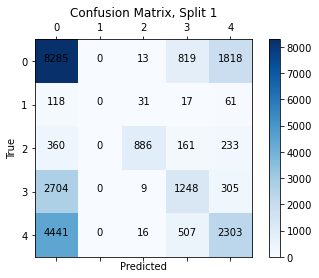

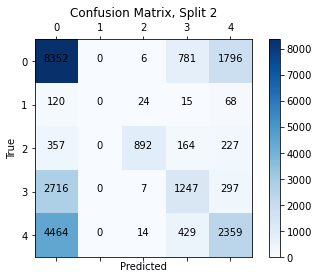

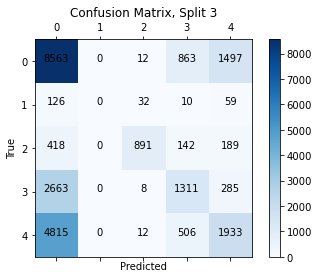

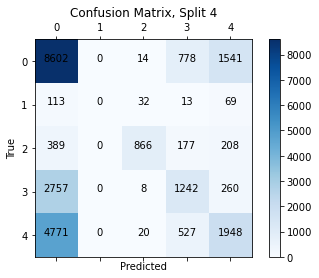

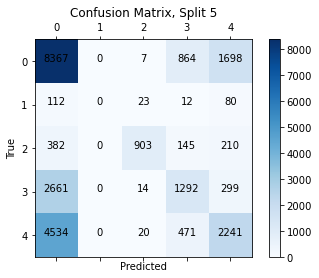

In [67]:
clf_LR = LogisticRegression()
stratfit(clf_LR, out_data_pd, out_labels_pd, n_splits=5)
cv_scores_dict['1. Logistic Regression\nwith Raw Data'] = check_variance(clf_LR
                                                                         , out_data_pd
                                                                         , out_labels_pd
                                                                         , n_splits = 5
                                                                        )
f1_dict['Logistic Regression with Raw Data'] = ['%.2f' % np.mean(accuracy_temp_list), '%.2f' % np.mean(f1_temp_list), '']
f1_temp_list = []
accuracy_temp_list = []


TRAIN: 97340 and TEST: 24335

For train data:
                  precision    recall  f1-score   support

       Adoption       0.66      0.85      0.74     43741
           Died       0.74      0.13      0.22       908
     Euthanasia       0.93      0.62      0.74      6560
Return to Owner       0.64      0.50      0.56     17067
       Transfer       0.72      0.59      0.65     29064

       accuracy                           0.69     97340
      macro avg       0.74      0.54      0.58     97340
   weighted avg       0.69      0.69      0.68     97340

For test data:
                  precision    recall  f1-score   support

       Adoption       0.60      0.76      0.67     10935
           Died       0.21      0.03      0.05       227
     Euthanasia       0.83      0.55      0.66      1640
Return to Owner       0.44      0.34      0.38      4266
       Transfer       0.59      0.48      0.53      7267

       accuracy                           0.58     24335
      macro avg    

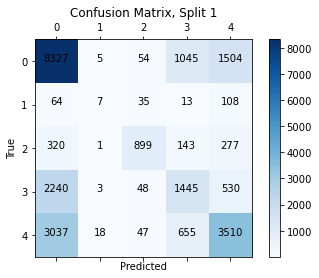

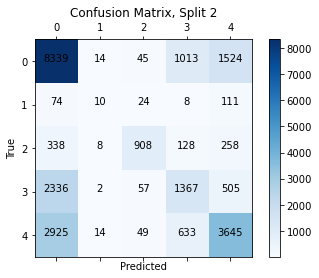

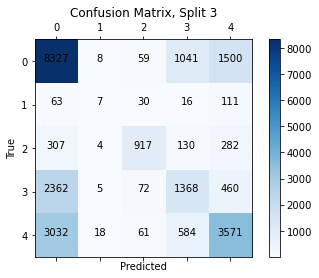

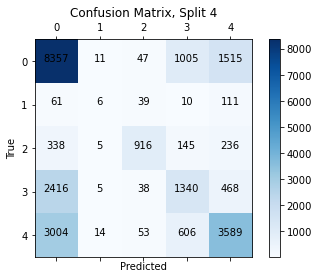

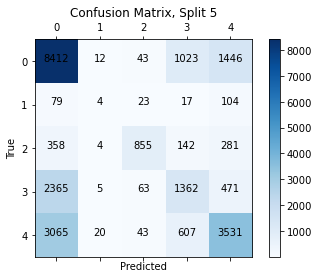

In [68]:
clf_DT = DecisionTreeClassifier()
stratfit(clf_DT, out_data_pd, out_labels_pd, n_splits = 5)
cv_scores_dict['2. Decision Tree\nwith Raw Data'] = check_variance(clf_DT
                                                                   , out_data_pd
                                                                   , out_labels_pd
                                                                   , n_splits = 5
                                                                  )
f1_dict['Decision Tree with Raw Data'] = ['%.2f' % np.mean(accuracy_temp_list), '%.2f' % np.mean(f1_temp_list), '']
f1_temp_list = []
accuracy_temp_list = []


TRAIN: 97340 and TEST: 24335

For train data:
                  precision    recall  f1-score   support

       Adoption       0.67      0.83      0.74     43741
           Died       0.81      0.11      0.19       908
     Euthanasia       0.93      0.62      0.74      6560
Return to Owner       0.64      0.50      0.56     17067
       Transfer       0.70      0.61      0.65     29064

       accuracy                           0.69     97340
      macro avg       0.75      0.53      0.58     97340
   weighted avg       0.69      0.69      0.68     97340

For test data:
                  precision    recall  f1-score   support

       Adoption       0.60      0.74      0.66     10935
           Died       0.25      0.02      0.04       227
     Euthanasia       0.84      0.53      0.65      1640
Return to Owner       0.43      0.33      0.37      4266
       Transfer       0.59      0.51      0.55      7267

       accuracy                           0.58     24335
      macro avg    

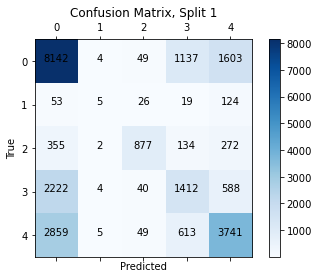

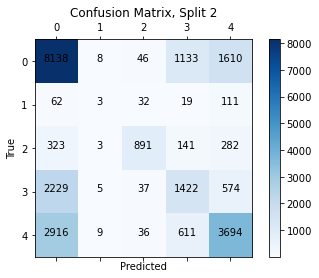

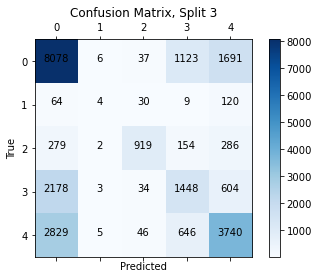

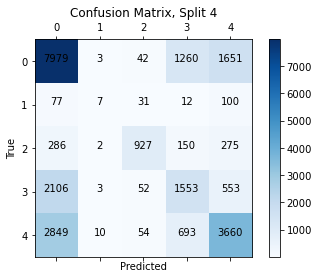

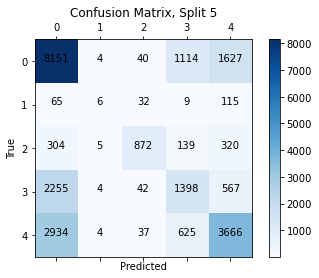

In [69]:
clf_RF = RandomForestClassifier()
stratfit(clf_RF, out_data_pd, out_labels_pd, n_splits=5)
cv_scores_dict['3. Random Forest\nwith Raw Data'] = check_variance(clf_RF
                                                                   , out_data_pd
                                                                   , out_labels_pd
                                                                   , n_splits = 5
                                                                  )
f1_dict['Random Forest with Raw Data'] = ['%.2f' % np.mean(accuracy_temp_list), '%.2f' % np.mean(f1_temp_list), '']
f1_temp_list = []
accuracy_temp_list = []

In [73]:
# Create pandas dataframe with all f1-scores for all classifiers of interest.
cv_scores_df = pd.DataFrame.from_dict(cv_scores_dict)
print('Weighted F1-Score Distributions')
cv_scores_df

Weighted F1-Score Distributions


,1. Logistic Regression\nwith Raw Data,2. Decision Tree\nwith Raw Data,3. Random Forest\nwith Raw Data
0,0.492784,0.569238,0.566064
1,0.503614,0.570370,0.568384
2,0.500595,0.566973,0.573808
3,0.488044,0.570685,0.576330
4,0.498651,0.569152,0.571851


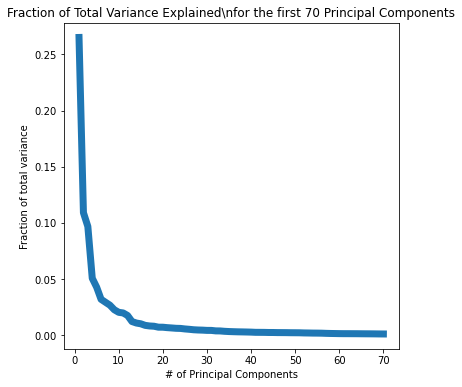

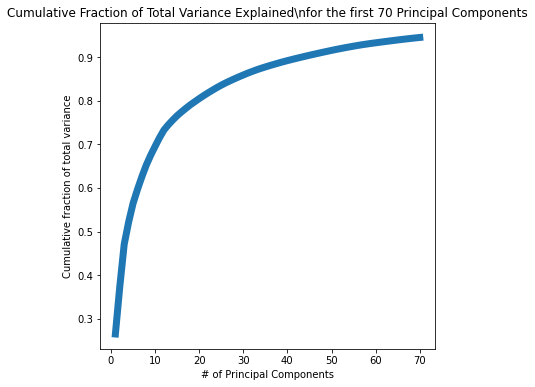

In [70]:
#Figure out best k to use - go up to 70.
k = 70

# Set the number of principal components.
pca = PCA(n_components=k)

# Fit principal component analysis.
pca.fit(out_data_pd)

# Store explained variance ratio with corresponding k.
results = np.column_stack(([i for i in range(1, k+1)],pca.explained_variance_ratio_))

# Plot the relationship of explained variance ratio.
fig1 = plt.figure(figsize = (6,6))
ax = fig1.add_subplot(111)
ax.set_title('Fraction of Total Variance Explained' 
             '\\nfor the first {} Principal Components'.format(k)
            )
plt.plot([i for i in range(1, k+1)],pca.explained_variance_ratio_, linewidth=7.0)
ax.set_xlabel('# of Principal Components')
ax.set_ylabel('Fraction of total variance')
fig1.show()

# Plot the cumulative explained variance ratio.
fig2 = plt.figure(figsize = (6,6))
ax = fig2.add_subplot(111)
ax.set_title('Cumulative Fraction of Total Variance Explained' 
             '\\nfor the first {} Principal Components'.format(k)
            )
plt.plot([i for i in range(1, k+1)], np.cumsum(pca.explained_variance_ratio_), linewidth=7.0)
ax.set_xlabel('# of Principal Components')
ax.set_ylabel('Cumulative fraction of total variance')
fig2.show()

In [72]:
model = PCA(n_components=20).fit(out_data_pd)
X_pc = model.transform(out_data_pd)

# number of components
n_pcs= model.components_.shape[0]

#get the index of the most important feature on EACH component
# LIST COMPREHENSION HERE
most_important = [np.abs(model.components_[i]).argmax() for i in range(n_pcs)]

initial_feature_names = out_data_pd.columns
# get the names
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]

# LIST COMPREHENSION HERE AGAIN
dic = {'PC{}'.format(i): most_important_names[i] for i in range(n_pcs)}
dic

{'PC0': 'Cat',
 'PC1': 'White',
 'PC2': 'Gender(Male=1)',
 'PC3': 'Black',
 'PC4': 'Other',
 'PC5': 'Pit Bull',
 'PC6': 'Labrador Retriever',
 'PC7': 'Chihuahua Shorthair',
 'PC8': 'Tan',
 'PC9': 'Brown Tabby',
 'PC10': 'Chihuahua Shorthair',
 'PC11': 'Tricolor',
 'PC12': 'German Shepherd',
 'PC13': 'Orange Tabby',
 'PC14': 'Tricolor',
 'PC15': 'AgeuponOutcome_norm',
 'PC16': 'Blue',
 'PC17': 'AgeuponOutcome_norm',
 'PC18': 'Australian Cattle Dog',
 'PC19': 'Tortie'}